In [1]:
import sys, os, glob, h5py
import time, datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import PyMKID_USRP_functions as PUf
import PyMKID_resolution_functions as Prf
import TimestreamHelperFunctions as Thf

In [3]:
## MB Results come from fitting a temperature scan at a specified RF power
MB_fit_vals = np.array([4.24216+9.75e-6, 
                        0.177  ,
                        0.0125 ,
                        4.1e7  ]) ## [ F0 [GHz] , Delta , alpha , Qi0 ]

In [ ]:
## 6/07 Al Runs
series_list = np.array([
#     "20220607_095300" , 
    "20220607_100452" , 
    "20220607_100858" , 
    "20220607_101139" , 
    "20220607_102016" , 
    "20220607_102257" , 
    "20220607_102619" , 
    "20220607_103040" , 
    "20220607_103312" , 
    "20220607_103536" , 
    "20220607_103820" , 
    "20220607_104103" , 
    "20220607_104418" , 
    "20220607_104739" , 
#     "20220607_105011" 
])

P_min = -70 ; P_max = 0 ; P_step = 5
powers_list = np.arange(start=P_min, stop=P_max+P_step, step=P_step)[1:-1]

In [4]:
## 6/19 Al Runs
series_list = np.array([
    "20220619_155709",
    "20220619_153053",
    "20220619_152817",
    "20220619_152542",
    "20220619_152210",
    "20220619_151914",
#     "20220619_151634",
#     "20220619_151405",
#     "20220619_150933",
#     "20220619_150645",
#     "20220619_150415",
#     "20220619_150117",
#     "20220619_145802",
#     "20220619_145536",
#     "20220619_145204"
])

P_min = -70 ; P_max = 0 ; P_step = 5
powers_list = np.arange(start=P_max, stop=P_min-P_step, step=-P_step)[:6]#[3:-1]

In [ ]:
## 6/19 Nb7 Runs
series_list = np.array([
#     "20220619_171322",
#     "20220619_171119",
#     "20220619_170714",
    "20220619_170214",
    "20220619_170017",
    "20220619_165127",
    "20220619_164921",
    "20220619_164721",
    "20220619_164257",
    "20220619_164056",
    "20220619_162829",
    "20220619_162632",
    "20220619_161836",
    "20220619_161640",
    "20220619_160446"
])

P_min = -70 ; P_max = 0 ; P_step = 5
powers_list = np.arange(start=P_max, stop=P_min-P_step, step=-P_step)[3:]

In [5]:
for i in np.arange(len(series_list)):
    print(series_list[i], ":", powers_list[i], "dBc")

20220619_155709 : 0 dBc
20220619_153053 : -5 dBc
20220619_152817 : -10 dBc
20220619_152542 : -15 dBc
20220619_152210 : -20 dBc
20220619_151914 : -25 dBc


In [ ]:
sum_file, dly_file, vna_file, tone_files = Thf.GetFiles(series_list[2], verbose=True)
metadata, avg_frqs, avg_S21s = Thf.UnpackSummary(sum_file)

In [ ]:
powers, PSDs, res, timestreams = Thf.CleanPSDs(tone_files[0], vna_file, f_transient=0.075,
                                               charFs = avg_frqs,
                                               charZs = avg_S21s,
                                               MBresults = MB_fit_vals)

In [ ]:
PSDs.keys()

In [ ]:
plt.loglog(PSDs['f'],PSDs['kappa_1'])

In [ ]:
del powers, PSDs, res, timestreams

## Now package it all together

Line Delay file:  /data/USRP_Noise_Scans/20220619/20220619_155709/USRP_Delay_20220619_155709.h5
VNA scan file:    /data/USRP_Noise_Scans/20220619/20220619_155709/USRP_VNA_20220619_155709.h5
Timestream files: ['/data/USRP_Noise_Scans/20220619/20220619_155709/USRP_Noise_20220619_155709_delta0.h5']
Summary file:	 /data/USRP_Noise_Scans/20220619/20220619_155709/noise_averages_20220619_155709.h5
Will separate data into  6000 chunks to achieve the requested 1.00e+02  Hz low  end of the PSD
Additional decimation by 20 needed to achieve the requested 5.00e+04  Hz high end of the PSD
Will convert to resonator basis!
Will convert to quasiparticle basis!
doing additional decimation
sampling frequency plugged into welch is 50000
pulse time data already exists! If you set override=False, nothing will happen.
saving pulse time data to /data/USRP_Noise_Scans/20220619/20220619_155709/USRP_Noise_20220619_155709_delta0.h5 because override=True!
found 21 pulses
chunk length plugged into welch is 500
chun

/home/nexus-admin/NEXUS_RF/AnalysisScripts/PyMKID_resolution_functions.py:862: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(noise_data_file + '_timestream')


Line Delay file:  /data/USRP_Noise_Scans/20220619/20220619_152542/USRP_Delay_20220619_152542.h5
VNA scan file:    /data/USRP_Noise_Scans/20220619/20220619_152542/USRP_VNA_20220619_152542.h5
Timestream files: ['/data/USRP_Noise_Scans/20220619/20220619_152542/USRP_Noise_20220619_152542_delta0.h5']
Summary file:	 /data/USRP_Noise_Scans/20220619/20220619_152542/noise_averages_20220619_152542.h5
Will separate data into  6000 chunks to achieve the requested 1.00e+02  Hz low  end of the PSD
Additional decimation by 20 needed to achieve the requested 5.00e+04  Hz high end of the PSD
Will convert to resonator basis!
Will convert to quasiparticle basis!
doing additional decimation
sampling frequency plugged into welch is 50000
pulse time data already exists! If you set override=False, nothing will happen.
saving pulse time data to /data/USRP_Noise_Scans/20220619/20220619_152542/USRP_Noise_20220619_152542_delta0.h5 because override=True!
found 29 pulses
chunk length plugged into welch is 500
chun

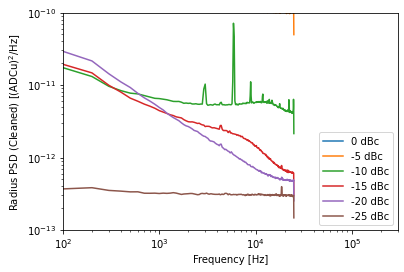

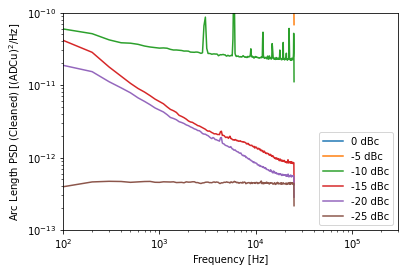

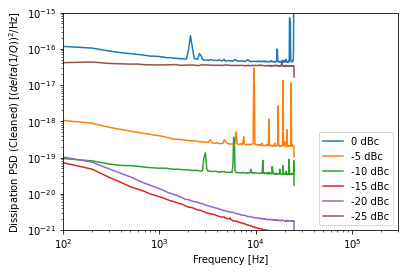

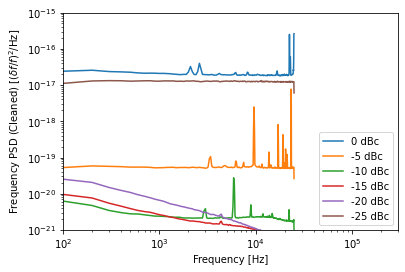

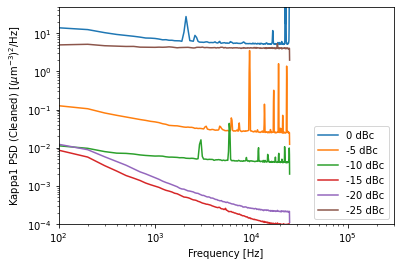

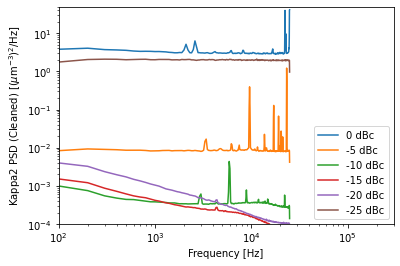

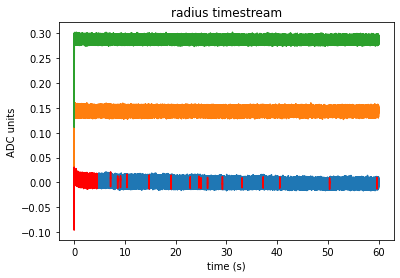

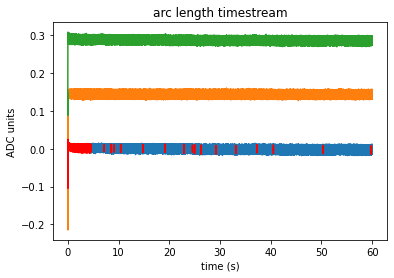

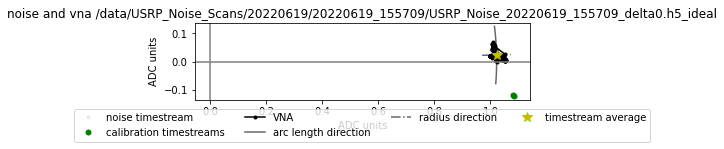

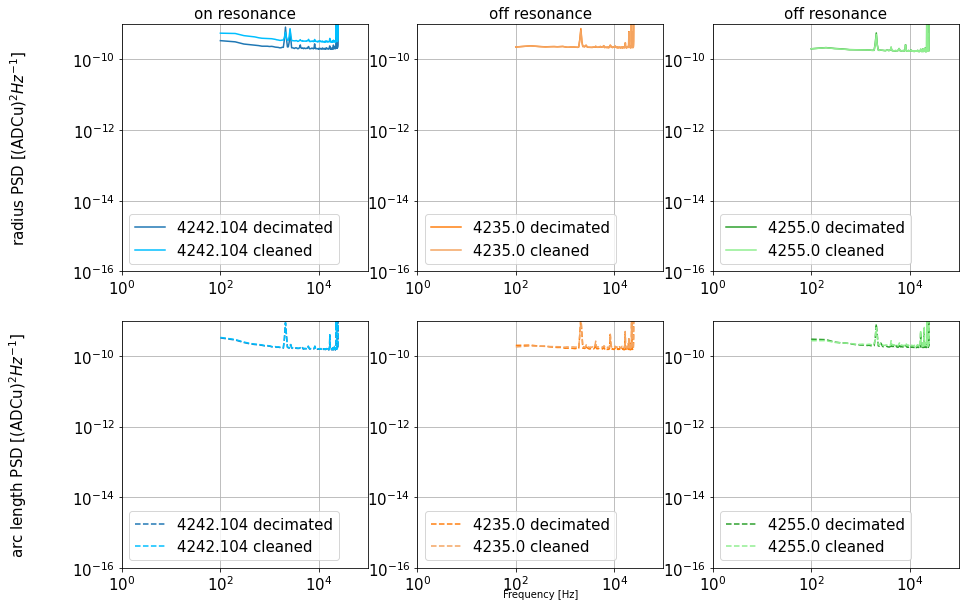

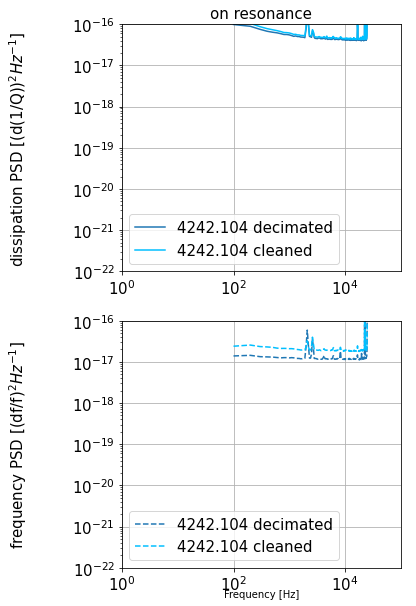

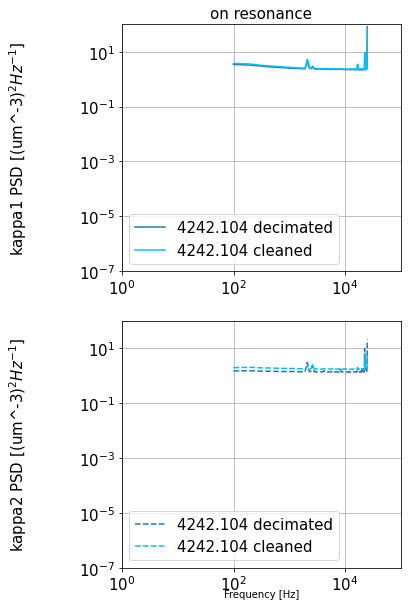

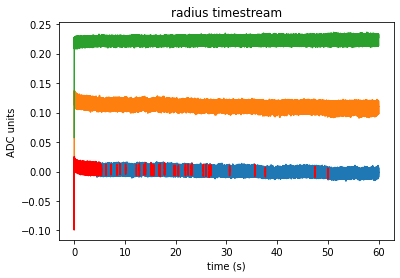

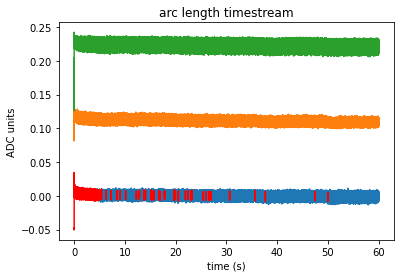

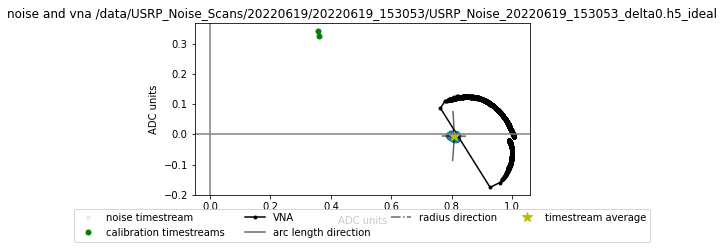

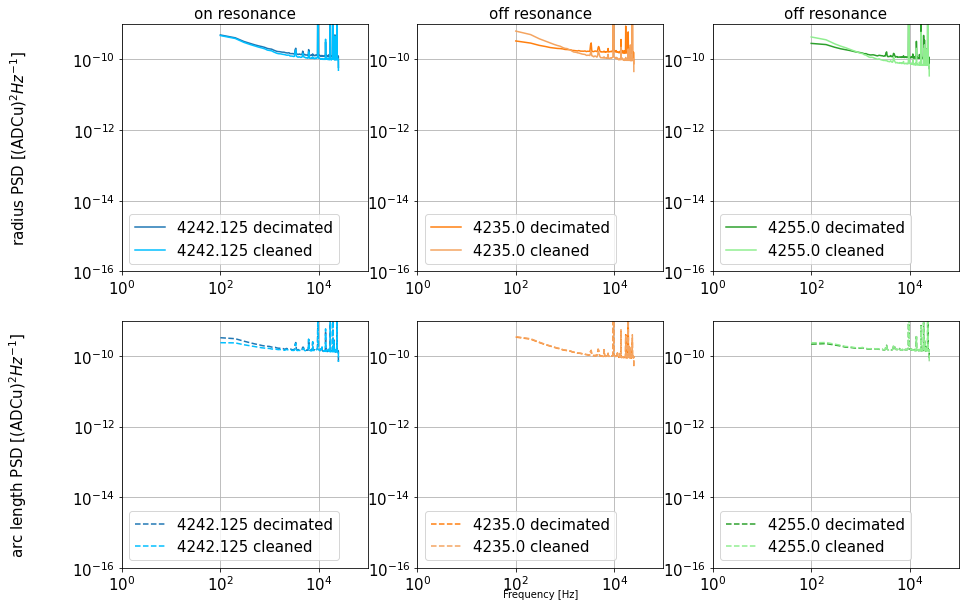

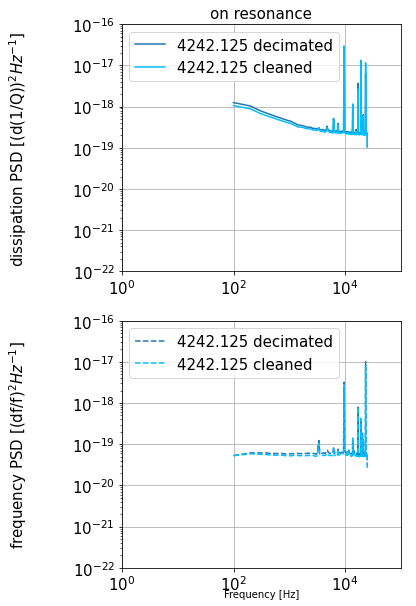

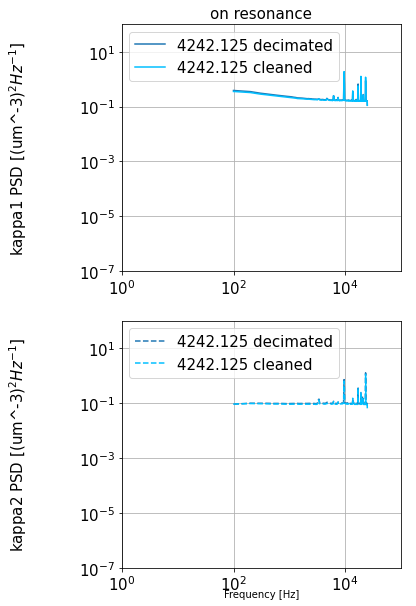

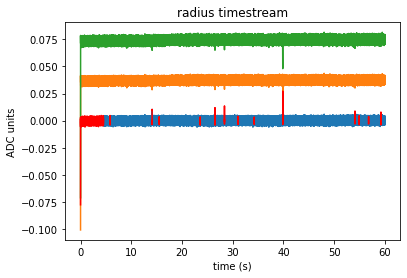

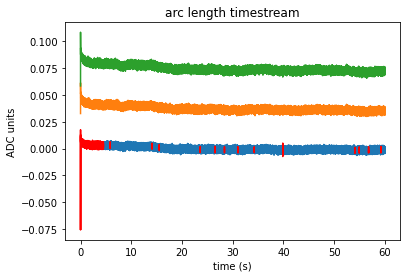

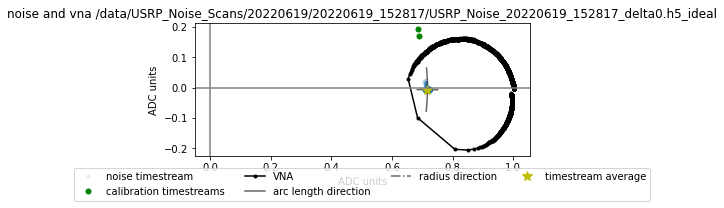

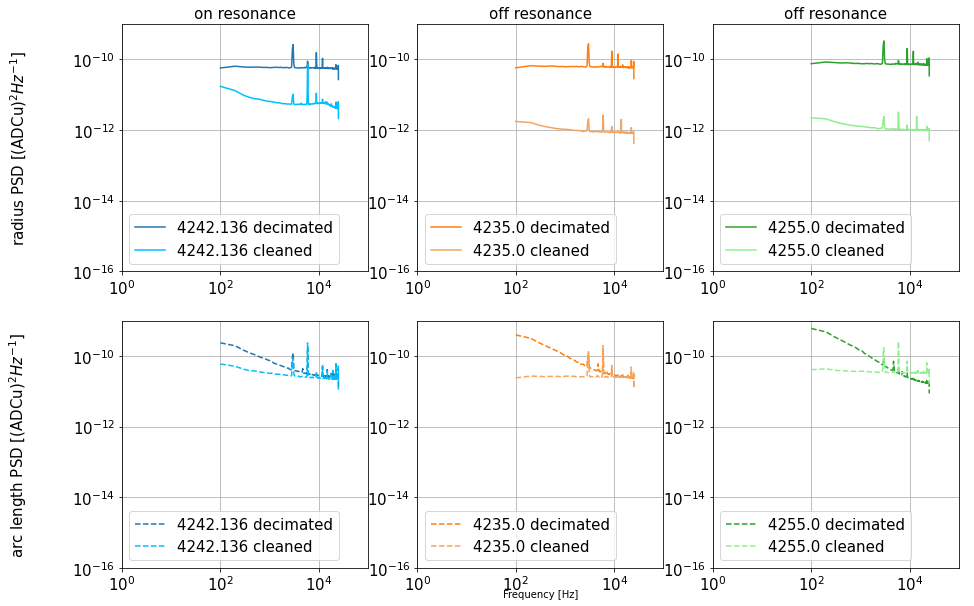

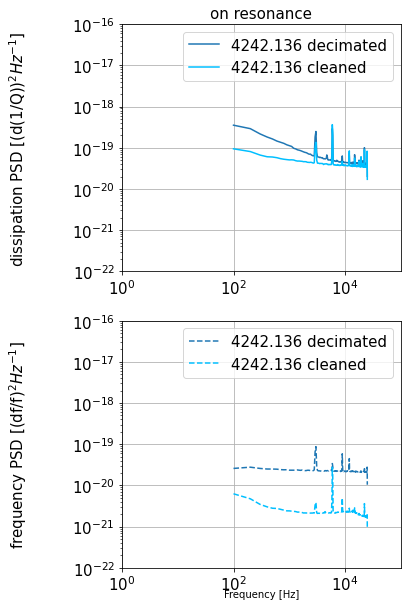

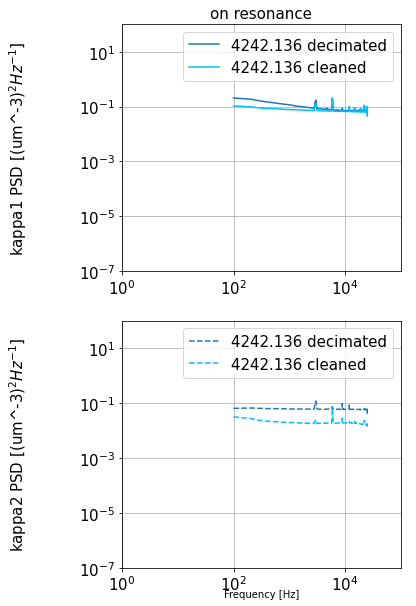

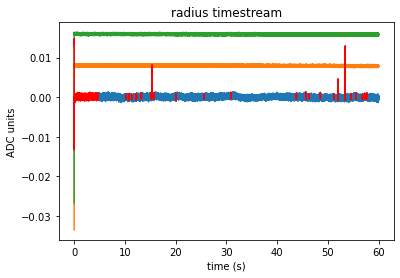

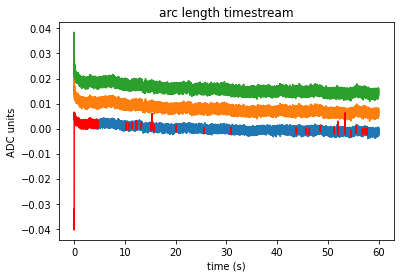

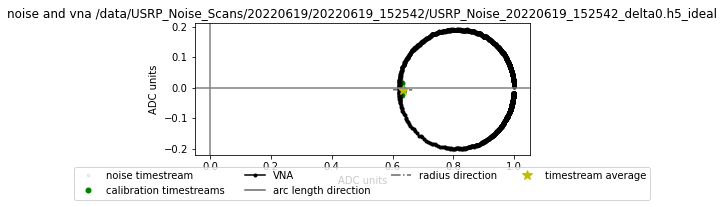

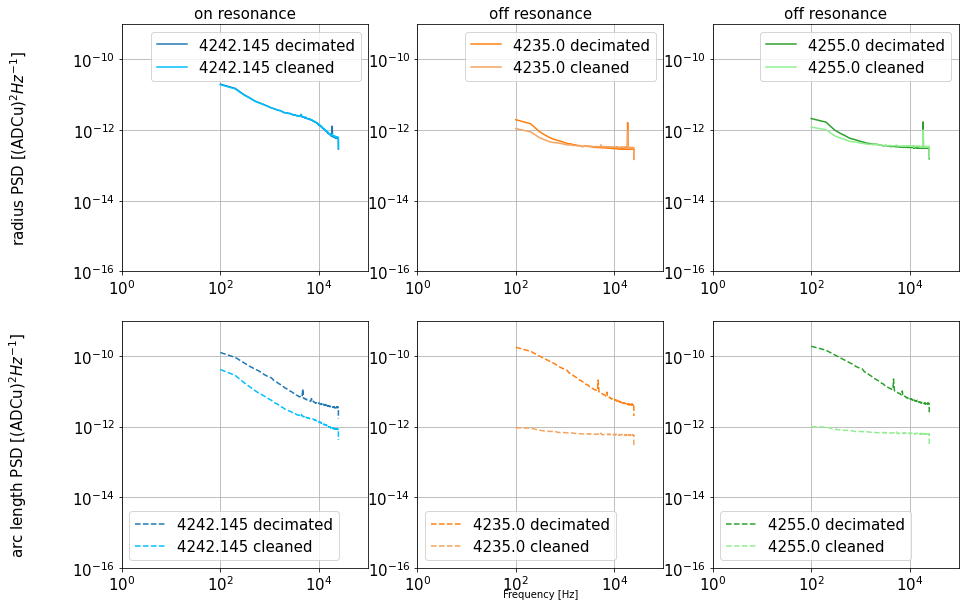

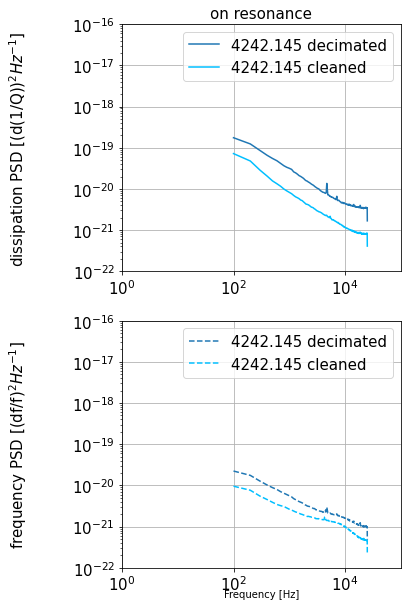

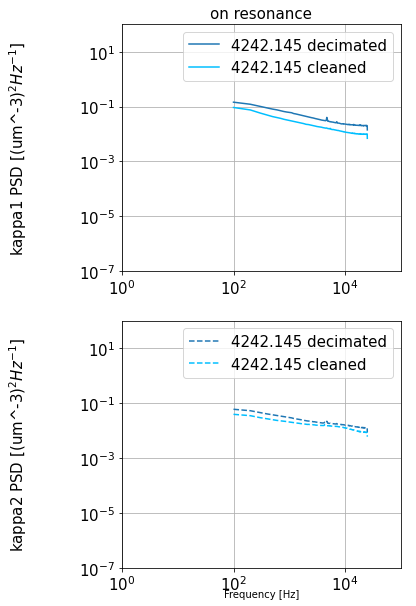

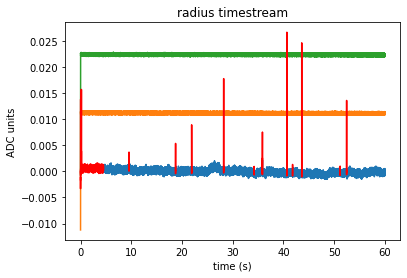

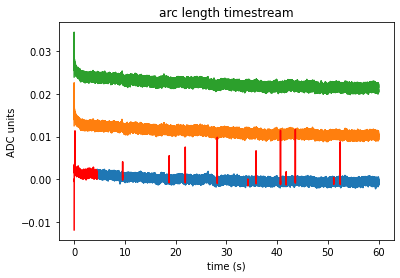

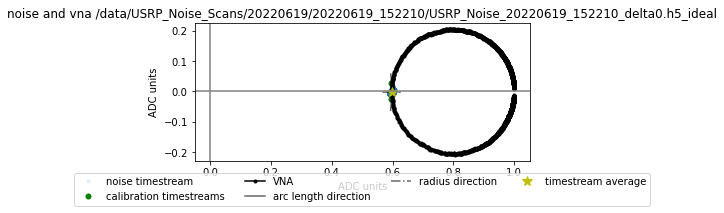

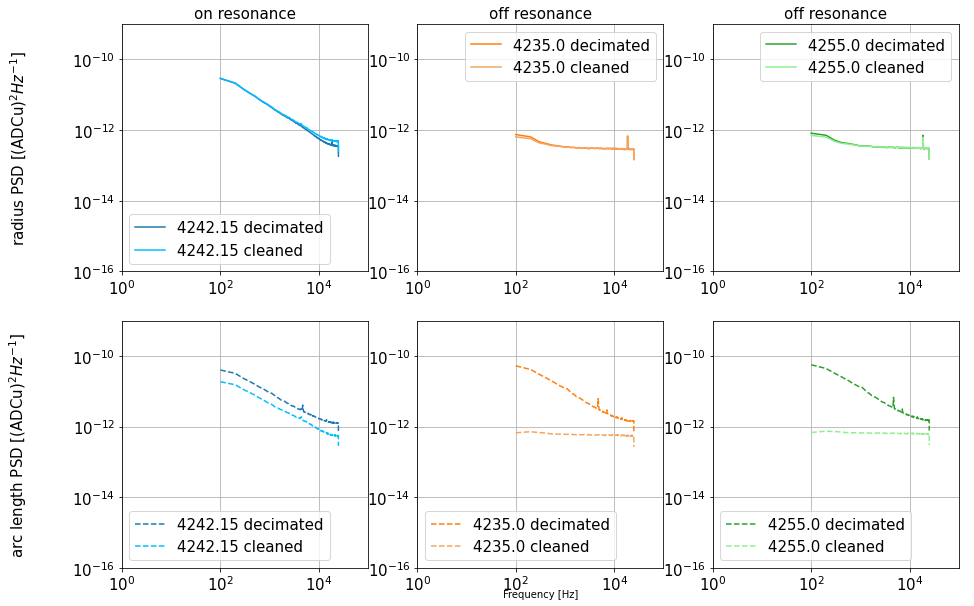

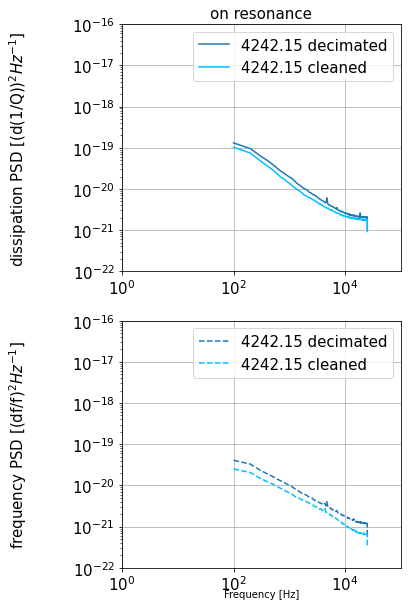

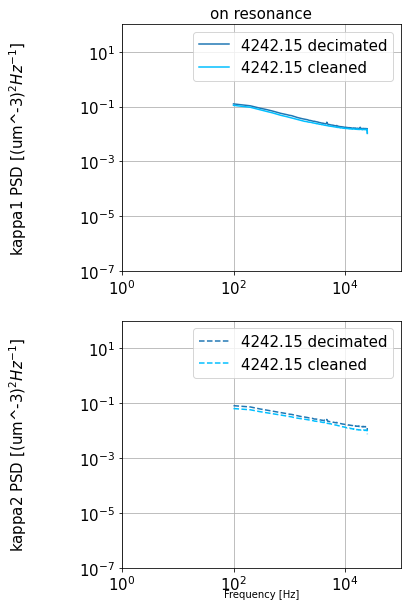

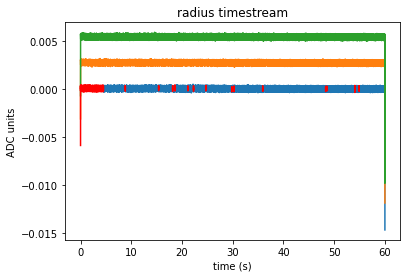

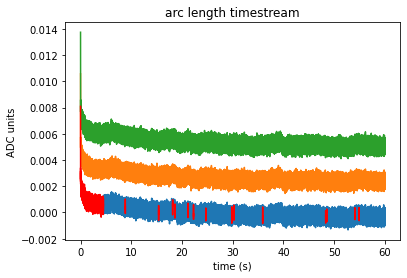

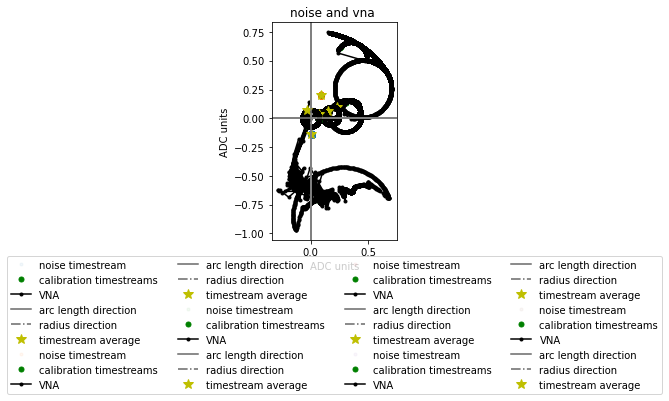

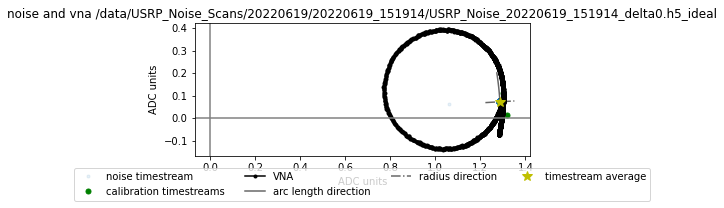

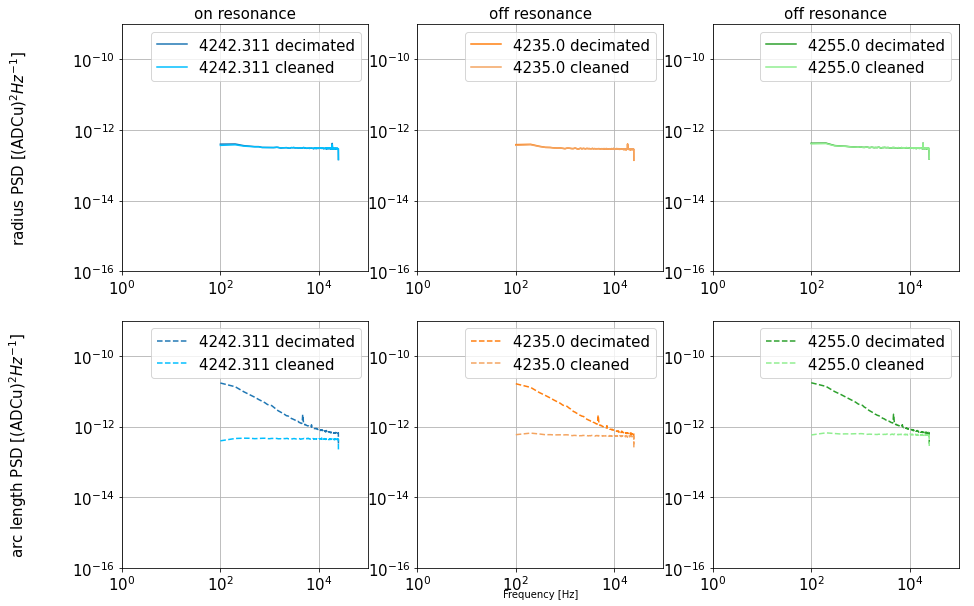

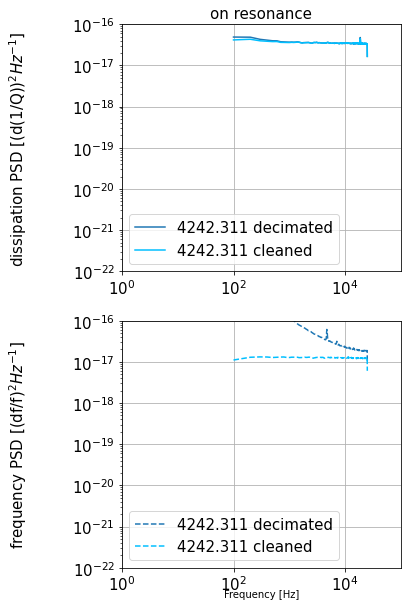

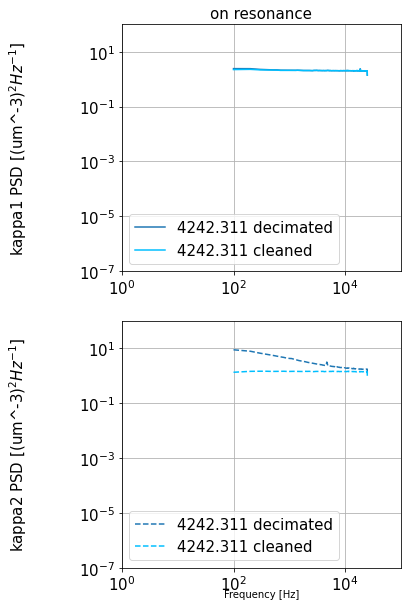

In [6]:
Thf.PlotPSDsByPower(series_list, powers_list, fHz_range = [1e2,3e5], \
	e_b_PSDrange = [1e-13,1e-10], r_b_PSDrange = [1e-21,1e-15], \
	q_b_PSDrange = [1e-4,5e1], MB_fit_result=MB_fit_vals)